## **Import Libraries**

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import gensim
import gensim.downloader as gloader
from tqdm import tqdm
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import glob
from pathlib import Path
import matplotlib.pyplot as plt


## **Data preparation**
- Dowlodaing and unzipping dataset
- Spliting dataset
- Structure dataset

In [2]:
'''
Dowlodaing and unzipping dataset
'''
def check_folder(f):
    '''function for check if the folder is exist, creat one if not exist.
    Input: f: str, folder name 
    '''
    if not os.path.exists(f):
        os.mkdir(f)
    else:
        print("folder:",f, "exits")


data_folder = os.getcwd()
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

check_folder(data_folder)

with urlopen(url) as response:
    zipfile = ZipFile(BytesIO(response.read()))
    zipfile.extractall(path=data_folder)
    
print("dowlodaing and unzipping dataset to",data_folder)


folder: /kaggle/working exits
dowlodaing and unzipping dataset to /kaggle/working


In [3]:
'''
Spliting dataset
'''

Path(os.getcwd()).absolute()

train_folder = os.path.join(os.getcwd(), "train") 
val_folder = os.path.join(os.getcwd(), "val") 
test_folder = os.path.join(os.getcwd(), "test") 

check_folder(train_folder)
check_folder(val_folder)
check_folder(test_folder)

files = glob.glob('./dependency_treebank/*')


#move files into new folders
for i in range (1, len(files) + 1):
    new = ''
    if i <= 100:
        new = os.path.join(train_folder, files[i-1].split('/')[-1])
        #print(new)
    elif 100 < i <= 150:
        new = os.path.join(val_folder, files[i-1].split('/')[-1])
        #print(new)
    else:
        new = os.path.join(test_folder, files[i-1].split('/')[-1])
        #print(new)
    shutil.move(files[i-1], new)



In [4]:
'''
Structure dataset
'''


def load_file(file_name, file_path): 
    '''
    Extract information from dp
    Input: 
        file name: str, file name
        file path: str, file path of the file name
    '''
    with open(file_path, "r") as file_ds: 
        sentence_list = []
        word_list = []
        tag_list = []

        for line in file_ds:
            splitted_row = line.split("	")
            if len(splitted_row) == 3:
                word_list.append(splitted_row[0].lower())
                tag_list.append(splitted_row[1])
              
    sentence_list.append({"name": file_name, "words" : word_list, "tags" : tag_list})
    return sentence_list

def file2df(part):
    '''Transform files into a data frame
    Input: 
        part: str, one of 'train','val','test'
    Output: DataFrame
    '''
    current_path = os.path.join(os.getcwd(), part)
    ds_files = os.listdir(current_path)
    sentences_list = []

    for ds_file in ds_files:
        sentences_list = sentences_list + load_file(ds_file, os.path.join(current_path, ds_file))

    df = pd.DataFrame.from_dict(sentences_list)
        
    return df


df_train = file2df("train")
df_val = file2df("val")
df_test = file2df("test")
df_train.head(5)

,name,words,tags
0,wsj_0180.dp,"[genetics, institute, inc., ,, cambridge, ,, m...","[NNP, NNP, NNP, ,, NNP, ,, NNP, ,, VBD, PRP, V..."
1,wsj_0114.dp,"[after, years, of, struggling, ,, the, los, an...","[IN, NNS, IN, VBG, ,, DT, NNP, NNP, NNP, NNP, ..."
2,wsj_0015.dp,"[commonwealth, edison, co., was, ordered, to, ...","[NNP, NNP, NNP, VBD, VBN, TO, VB, IN, $, CD, C..."
3,wsj_0175.dp,"[sony, corp., completed, its, tender, offer, f...","[NNP, NNP, VBD, PRP$, NN, NN, IN, NNP, NNPS, N..."
4,wsj_0189.dp,"[ralston, purina, co., reported, a, 47, %, dec...","[NNP, NNP, NNP, VBD, DT, CD, NN, NN, IN, NN, N..."


## Embedding the words
- Tokenization of training dataset (V1): building vocabulary based on the given dataset (here the dataset no need to )
- OOV and embedding computing using glove
- Add embeddings to the vocabulary, so to obtain vocabulary V2,OOV2,V3,OOV3,V4
- Sequence embedding with padding

In [5]:
'''
Tokenization of traning dataset
'''

from collections import OrderedDict
from typing import OrderedDict


def build_vocabulary(df):
    '''
    Building vocabulary based on the given dataset words and tags
    '''

    idx2word = OrderedDict()
    word2idx = OrderedDict()

    idx2tag = OrderedDict()
    tag2idx = OrderedDict()
    
    curr_idx = 1 
    for token in tqdm(df['words'].sum()):
        if token not in word2idx:
            word2idx[token] = curr_idx
            idx2word[curr_idx] = token
            curr_idx += 1

    curr_idx = 1 # Start at 1 since 0 is reserved for padding.
    for tag in tqdm(np.unique(df['tags'].sum())):
        if tag not in tag2idx:
            tag2idx[tag] = curr_idx
            idx2tag[curr_idx] = tag
            curr_idx += 1

    return idx2word, word2idx, idx2tag, tag2idx

idx2word_train, word2idx_train, idx2tag_train, tag2idx_train = build_vocabulary(df_train)



100%|██████████| 45/45 [00:00<00:00, 151723.22it/s]


In [6]:
'''
OOV computing and embedding using glove
'''
def load_glove_embedding(embedding_dimension: int) -> gensim.models.keyedvectors.KeyedVectors:
    '''
    function for loading glove embedding
    '''
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        embedded_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding dimension: choose between: 50, 100, 200, 300.")
        raise e

    return embedded_model

def check_OOV_terms(embedding_model, word_listing):
    '''
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.
    '''

    embedding_vocabulary = set(embedding_model.key_to_index)
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

def build_embedding_matrix(embedding_model, embedding_dimension,
                           word2idx, vocab_size, oov_terms) -> np.ndarray:
    '''
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model.
    '''

    # Note: we take (vocab_size) + 1 since we start counting by 1, having reserved 0 for the padding.
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dimension), dtype = np.float32) 

    for word, idx in tqdm(word2idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low = -0.05, high = 0.05, size = embedding_dimension)
        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

embedding_dimension = 300
embedding_model = load_glove_embedding(embedding_dimension) # Load embedding model with the chosen dimensionality
oov_terms_train = check_OOV_terms(embedding_model, df_train['words'].sum())
print(f'There are {len(oov_terms_train)} OOVs in the training set.')

embedding_matrix_train = build_embedding_matrix(embedding_model, embedding_dimension, word2idx_train, len(word2idx_train), oov_terms_train)
print("Embedding matrix shape: {}".format(embedding_matrix_train.shape))



[==================================================] 100.0% 376.1/376.1MB downloaded
There are 378 OOVs in the training set.


100%|██████████| 7354/7354 [00:00<00:00, 145802.29it/s]

Embedding matrix shape: (7355, 300)


In [7]:
'''
Add embeddings to the vocabulary, so to obtain vocabulary V2,OOV2,V3,OOV3,V4
'''
# V2,OOV2: creation of vocaboulary for the validation set and extraction of OOVs
idx2word_val, word2idx_val, idx2tag_val, tag2idx_val = build_vocabulary(df_val)
oov_terms_val = check_OOV_terms(embedding_model, df_val['words'].sum())
oov_terms_val = list(set(oov_terms_val).difference(set(oov_terms_train)))
print(f'There are {len(oov_terms_val)} new OOVs in the validation set.') #OOV2

embedding_matrix_val = build_embedding_matrix(embedding_model, embedding_dimension, word2idx_val, len(word2idx_val), oov_terms_val) #V2
print("Embedding matrix shape: {}.".format(embedding_matrix_val.shape))
print('\n')


# V3,OOV3: creation of vocaboulary for the test set and extraction of his OOVs.
idx2word_test, word2idx_test, idx2tag_test, tag2idx_test = build_vocabulary(df_test) 
oov_terms_test = check_OOV_terms(embedding_model, df_test['words'].sum())
oov_terms_test = list(set(oov_terms_test).difference((set(oov_terms_train).union(set(oov_terms_val)))))
print(f'There are {len(oov_terms_test)} new OOVs in the test set.') #OOV3

embedding_matrix_test = build_embedding_matrix(embedding_model, embedding_dimension, word2idx_test, len(word2idx_test), oov_terms_test)
print("Embedding matrix shape: {}.".format(embedding_matrix_test.shape)) #V3
print('\n')

# V4: whole embedding matrix
embedding_matrix = np.concatenate((embedding_matrix_train, embedding_matrix_val, embedding_matrix_test))
print("Embedding matrix shape: {}.".format(embedding_matrix.shape))


100%|██████████| 44/44 [00:00<00:00, 144972.02it/s]


There are 161 new OOVs in the validation set.


100%|██████████| 4914/4914 [00:00<00:00, 195513.24it/s]


Embedding matrix shape: (4915, 300).




100%|██████████| 41/41 [00:00<00:00, 247790.29it/s]


There are 137 new OOVs in the test set.


100%|██████████| 4139/4139 [00:00<00:00, 202806.36it/s]

Embedding matrix shape: (4140, 300).


Embedding matrix shape: (16410, 300).


In [8]:
'''
Sequence embedding with padding
'''

from keras.preprocessing.sequence import pad_sequences
from typing import OrderedDict

def get_matrixes(dataframe, max_sequence_length, word2idx, tag2idx):
  # Transform all words in the dataframe into their corresponding index.
    word_matrix = [[word2idx[dataframe['words'][j][i]] # j selects the row, i selects the word.
                for i in range(len(dataframe['words'][j]))] 
                for j in range(len(dataframe))] 

    tag_matrix = [[tag2idx[dataframe['tags'][j][i]] # j selects the row, i selects the word.
               for i in range(len(dataframe['tags'][j]))] 
               for j in range(len(dataframe))] 

    # Turn the list of lists into a matrix.
    for i in range(len(word_matrix)):
        word_matrix[i] = np.asarray(word_matrix[i])
    word_matrix = np.asarray(word_matrix);

    for i in range(len(tag_matrix)):
        tag_matrix[i] = np.asarray(tag_matrix[i])
    tag_matrix = np.asarray(tag_matrix);

    # Pad the sequences into the same length. Note that we need to pad to right since it's needed for Keras masking system.
    word_matrix = pad_sequences(word_matrix, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
    tag_matrix = pad_sequences(tag_matrix, maxlen = max_sequence_length, padding = 'post', truncating = 'post')

    # Add dimension to tag matrix to conform it to the net.
    tag_matrix = np.expand_dims(tag_matrix, axis = 2)

    return word_matrix, tag_matrix

word2idx = OrderedDict()

word2idx.update(word2idx_train)
word2idx.update(word2idx_test)
word2idx.update(word2idx_val)

tag2idx = OrderedDict()

tag2idx.update(tag2idx_train)
tag2idx.update(tag2idx_test)
tag2idx.update(tag2idx_val)
maximum_sequence_length = max([len(sentence) for sentence in df_train['words']])
training = get_matrixes(df_train, maximum_sequence_length, word2idx, tag2idx)
validation = get_matrixes(df_val, maximum_sequence_length, word2idx, tag2idx)
test = get_matrixes(df_test, maximum_sequence_length, word2idx, tag2idx)

print(f'The training set contains {training[0].shape[0]} sentences, has a maximum sequence length of {maximum_sequence_length}.')
print(f'The validation set contains {validation[0].shape[0]} sentences, has a maximum sequence length of {maximum_sequence_length}')
print(f'The test set contains {test[0].shape[0]} sentences, has a maximum sequence length of {maximum_sequence_length}.')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


The training set contains 100 sentences, has a maximum sequence length of 2900.
The validation set contains 50 sentences, has a maximum sequence length of 2900
The test set contains 49 sentences, has a maximum sequence length of 2900.


## Baseline model--SimpleRNN

2022-06-12 12:36:35.279033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 12:36:35.386856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 12:36:35.387682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 12:36:35.388838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2900, 300)         4923000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2900, 128)         54912     
_________________________________________________________________
time_distributed (TimeDistri (None, 2900, 46)          5934      
Total params: 4,983,846
Trainable params: 60,846
Non-trainable params: 4,923,000
_________________________________________________________________
Epoch 1/20


2022-06-12 12:36:37.910039: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4/4 [==============================] - 17s 4s/step - loss: 0.5471 - acc: 0.1808 - val_loss: 0.4253 - val_acc: 0.3472
Epoch 2/20
4/4 [==============================] - 19s 5s/step - loss: 0.3748 - acc: 0.3769 - val_loss: 0.3633 - val_acc: 0.4098
Epoch 3/20
4/4 [==============================] - 15s 4s/step - loss: 0.3254 - acc: 0.4691 - val_loss: 0.3291 - val_acc: 0.4927
Epoch 4/20
4/4 [==============================] - 16s 4s/step - loss: 0.2969 - acc: 0.5278 - val_loss: 0.3408 - val_acc: 0.4123
Epoch 5/20
4/4 [==============================] - 18s 4s/step - loss: 0.2886 - acc: 0.5187 - val_loss: 0.2940 - val_acc: 0.5406
Epoch 6/20
4/4 [==============================] - 15s 4s/step - loss: 0.2604 - acc: 0.5761 - val_loss: 0.2802 - val_acc: 0.5514
Epoch 7/20
4/4 [==============================] - 19s 5s/step - loss: 0.2483 - acc: 0.5888 - val_loss: 0.2779 - val_acc: 0.5635
Epoch 8/20
4/4 [==============================] - 16s 4s/step - loss: 0.2408 - acc: 0.5995 - val_loss: 0.2619 - val

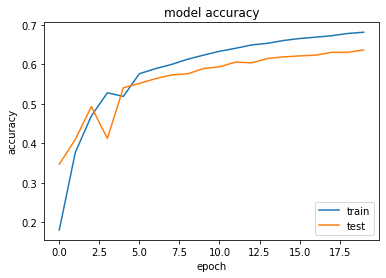

In [9]:
# create architecture

## Neural network model
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Dense, TimeDistributed, Input, Masking, Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


def plot_metrics(model_training):
    # visualise training history
    plt.plot(model_training.history['acc'])
    plt.plot(model_training.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc="lower right")
    plt.show()

hidden_nodes = 128
number_of_tags = len(set(df_train['tags'].sum())) + 1 # Note: +1 since we reserved 0 for padding.
optimizer = Adam(0.005, beta_1=0.1, beta_2=0.001, amsgrad=True)


base_model = Sequential()
base_model.add(Input(shape=(maximum_sequence_length, )))
# create embedding layer - usually the first layer in text problems
base_model.add(Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False))
base_model.add(SimpleRNN(hidden_nodes, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))
# add time distributed (output at each sequence) layer
base_model.add(TimeDistributed(Dense(number_of_tags, activation = 'softmax')))

# Compile the model.
base_model.compile(loss = 'sparse_categorical_crossentropy', 
                       optimizer = optimizer,
                       metrics = ['acc'])

# Check if the structure is correct.
base_model.summary()

# Train the model.
base_model_training = base_model.fit(x = training[0], y = training[1], 
                   epochs = 20, verbose=1,
                   validation_data = (validation[0], validation[1]))
plot_metrics(base_model_training)

## New models
- Model1--Bidirectional LSTM
- Model2--Bidirectional LSTM + Dense
- Model3--2 Bidirectional LSTM + Dense
- Model4--Bidirectional LSTM + GRU


In [10]:
print(training[0][0:2].shape,training[1][0:2].shape)

(2, 2900) (2, 2900, 1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2900, 300)         4923000   
_________________________________________________________________
bidirectional (Bidirectional (None, 2900, 256)         439296    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2900, 46)          11822     
Total params: 5,374,118
Trainable params: 451,118
Non-trainable params: 4,923,000
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 101s 25s/step - loss: 0.5080 - acc: 0.2071 - val_loss: 0.3918 - val_acc: 0.3479
Epoch 2/20
4/4 [==============================] - 97s 25s/step - loss: 0.3391 - acc: 0.4114 - val_loss: 0.3184 - val_acc: 0.4737
Epoch 3/20
4/4 [==============================] - 99s 25s/step - loss: 0.2755 - acc: 0.5442 - val_loss: 0.287

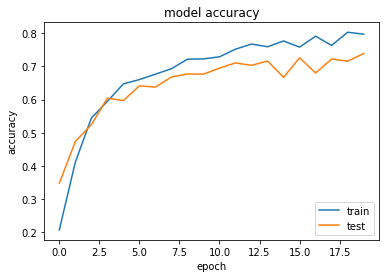

In [11]:
## Model1--Bidirectional LSTM
hidden_nodes = 128
number_of_tags = len(set(df_train['tags'].sum())) + 1 # Note: +1 since we reserved 0 for padding.
optimizer = Adam(0.01, beta_1=0.1, beta_2=0.001, amsgrad=True)

model1 = Sequential()
model1.add(Input(shape=(maximum_sequence_length, )))
model1.add(Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False))
model1.add(Bidirectional(LSTM(hidden_nodes, return_sequences = True, recurrent_dropout = 0.10)))
model1.add(TimeDistributed(Dense(number_of_tags, activation = 'softmax')))

#build model

model1.compile(loss = 'sparse_categorical_crossentropy', 
                       #loss = focal_loss.SparseCategoricalFocalLoss(gamma = 2, class_weight = weights_list),
                       optimizer = optimizer,
                       metrics = ['acc'])
model1.summary()

# Train the model.
model1_training = model1.fit(x = training[0], y = training[1], 
                   epochs = 20, verbose=1,
                   validation_data = (validation[0], validation[1]))
plot_metrics(model1_training)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2900, 300)         4923000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2900, 256)         439296    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2900, 128)         32896     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 2900, 46)          5934      
Total params: 5,401,126
Trainable params: 478,126
Non-trainable params: 4,923,000
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 103s 25s/step - loss: 0.6149 - acc: 0.0876 - val_loss: 0.6301 - val_acc: 0.1453
Epoch 2/20
4/4 [==============================] - 98s 25s/step - loss: 0.5937 - acc: 0.1109 - val_loss: 0.

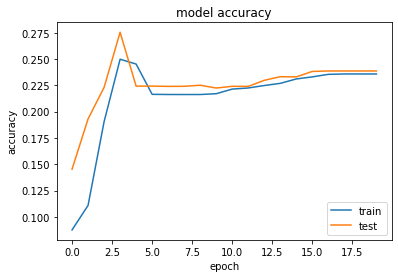

In [12]:
## Model2--Bidirectional LSTM+Dense

hidden_nodes = 128
number_of_tags = len(set(df_train['tags'].sum())) + 1 # Note: +1 since we reserved 0 for padding.
optimizer = Adam(0.01, beta_1=0.1, beta_2=0.001, amsgrad=True)

model2 = Sequential()
model2.add(Input(shape=(maximum_sequence_length, )))
model2.add(Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False))
model2.add(Bidirectional(LSTM(hidden_nodes, return_sequences = True, recurrent_dropout = 0.10)))

model2.add(TimeDistributed(Dense(128, activation = 'softmax')))
model2.add(TimeDistributed(Dense(number_of_tags, activation = 'softmax')))


model2.compile(loss = 'sparse_categorical_crossentropy', 
                       #loss = focal_loss.SparseCategoricalFocalLoss(gamma = 2, class_weight = weights_list),
                       optimizer = optimizer,
                       metrics = ['acc'])

model2.summary()

# Train the model.
model2_training = model2.fit(x = training[0], y = training[1], 
                   epochs = 20, verbose=1,
                   validation_data = (validation[0], validation[1]))
plot_metrics(model2_training)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2900, 300)         4923000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2900, 256)         439296    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 2900, 256)         394240    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 2900, 46)          11822     
Total params: 5,768,358
Trainable params: 845,358
Non-trainable params: 4,923,000
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 207s 51s/step - loss: 0.5563 - acc: 0.0890 - val_loss: 0.5214 - val_acc: 0.0914
Epoch 2/20
4/4 [==============================] - 199s 51s/step - loss: 0.4771 - acc: 0.1502 - val_loss: 0

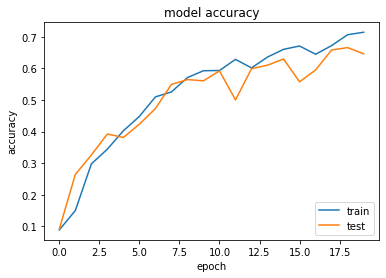

In [13]:
## Model3--2 Bidirectional LSTM

hidden_nodes = 128
number_of_tags = len(set(df_train['tags'].sum())) + 1 # Note: +1 since we reserved 0 for padding.
optimizer = Adam(0.005, beta_1=0.1, beta_2=0.001, amsgrad=True)

model3 = Sequential()
model3.add(Input(shape=(maximum_sequence_length, )))
model3.add(Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False))
model3.add(Bidirectional(LSTM(hidden_nodes, return_sequences = True, recurrent_dropout = 0.10)))
model3.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout = 0.10)))

model3.add(TimeDistributed(Dense(number_of_tags, activation = 'softmax')))


model3.compile(loss = 'sparse_categorical_crossentropy', 
                       #loss = focal_loss.SparseCategoricalFocalLoss(gamma = 2, class_weight = weights_list),
                       optimizer = optimizer,
                       metrics = ['acc'])

model3.summary()

# Train the model.
model3_training = model3.fit(x = training[0], y = training[1], 
                   epochs = 20, verbose=1,
                   validation_data = (validation[0], validation[1]))

plot_metrics(model3_training)

In [14]:
training[1].shape

(100, 2900, 1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2900, 300)         4923000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 2900, 256)         439296    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 2900, 256)         296448    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 2900, 46)          11822     
Total params: 5,670,566
Trainable params: 747,566
Non-trainable params: 4,923,000
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 229s 56s/step - loss: 0.5491 - acc: 0.1045 - val_loss: 0.4883 - val_acc: 0.2179
Epoch 2/20
4/4 [==============================] - 218s 55s/step - loss: 0.4402 - acc: 0.2702 - val_loss: 0

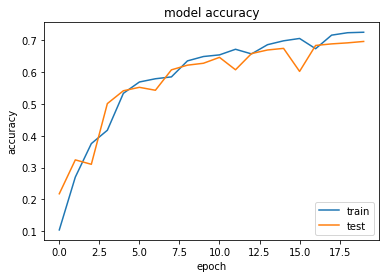

In [15]:
## Model4--Bidirectional LSTM+GRU


hidden_nodes = 128
number_of_tags = len(set(df_train['tags'].sum())) + 1 # Note: +1 since we reserved 0 for padding.
optimizer = Adam(0.005, beta_1=0.1, beta_2=0.001, amsgrad=True)

model4 = Sequential()
model4.add(Input(shape=(maximum_sequence_length, )))
model4.add(Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = 300,
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False))
model4.add(Bidirectional(LSTM(hidden_nodes, return_sequences = True, dropout=0.3,recurrent_dropout = 0.10)))
model4.add(Bidirectional(GRU(128, return_sequences = True,dropout=0.3, recurrent_dropout = 0.10)))

model4.add(TimeDistributed(Dense(number_of_tags, activation = 'softmax')))


model4.compile(loss = 'sparse_categorical_crossentropy', 
                       #loss = focal_loss.SparseCategoricalFocalLoss(gamma = 2, class_weight = weights_list),
                       optimizer = optimizer,
                       metrics = ['acc'])

model4.summary()

# Train the model.
model4_training = model4.fit(x = training[0], y = training[1], 
                   epochs = 20, verbose=1,
                   validation_data = (validation[0], validation[1]))

plot_metrics(model4_training)

## Model evaluation

In [16]:
loss1, accuracy1 = model1.evaluate(test[0], test[1], verbose = 1)
print("Model1 Loss: {0},\nAccuracy: {1}".format(loss1, accuracy1))

2/2 [==============================] - 3s 2s/step - loss: 0.1238 - acc: 0.7416
Model1 Loss: 0.12383577972650528,
Accuracy: 0.7416214942932129


In [17]:
loss2, accuracy2 = model2.evaluate(test[0], test[1], verbose = 1)
print("Model2 Loss: {0},\nAccuracy: {1}".format(loss2, accuracy2))

2/2 [==============================] - 3s 1s/step - loss: 0.4323 - acc: 0.2343
Model2 Loss: 0.4322543144226074,
Accuracy: 0.2343084067106247


In [18]:
loss3, accuracy3 = model3.evaluate(test[0], test[1], verbose = 1)
print("Model3 Loss: {0},\nAccuracy: {1}".format(loss3, accuracy3))

2/2 [==============================] - 6s 3s/step - loss: 0.1734 - acc: 0.6435
Model3 Loss: 0.17342257499694824,
Accuracy: 0.643500566482544


In [19]:
loss4, accuracy4 = model4.evaluate(test[0], test[1], verbose = 1)
print("Model4 Loss: {0},\nAccuracy: {1}".format(loss4, accuracy4))

2/2 [==============================] - 6s 3s/step - loss: 0.1439 - acc: 0.6974
Model4 Loss: 0.14391665160655975,
Accuracy: 0.6974040865898132


## Error analysis

In [20]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score

def model_analysis(model, test):
    classes = list(set([i for i in range(0,45)]).difference(set(range(0,9))))
    prediction = model.predict(test[0]) # Evaluate the test set.
    prediction = np.argmax(prediction, axis = -1) # Get the class with the highest index.
    print(classification_report(y_true = np.squeeze(test[1], axis = -1).ravel(), y_pred = prediction.ravel(), zero_division = 0, labels = classes))
    print(f'The f1-score is: {f1_score(y_true = np.squeeze(test[1], axis = -1).ravel(), y_pred = prediction.ravel(), average = "macro", zero_division = 0, labels = classes)}.')
    print(f'The global accuracy score on the test set is: {accuracy_score(y_true = np.squeeze(test[1], axis = -1).ravel(), y_pred = prediction.ravel())}.')
    cf_matrix = confusion_matrix(y_true = np.squeeze(test[1], axis = -1).ravel(), y_pred = prediction.ravel(), labels = classes)
    return cf_matrix


In [21]:
model_analysis(model1, test)

              precision    recall  f1-score   support

           9       0.99      0.98      0.98       495
          10       0.87      0.64      0.74       759
          11       0.97      0.97      0.97      1841
          12       1.00      0.94      0.97        16
          13       0.00      0.00      0.00         0
          14       0.89      0.92      0.91      2181
          15       0.46      0.49      0.48      1222
          16       0.68      0.50      0.58        82
          17       0.72      0.36      0.48        36
          18       0.00      0.00      0.00         0
          19       0.93      0.78      0.85       223
          20       0.55      0.74      0.63      2921
          21       0.01      0.63      0.02      1966
          22       0.00      0.00      0.00        58
          23       0.56      0.40      0.47      1402
          24       0.00      0.00      0.00        10
          25       0.94      0.99      0.96       179
          26       0.96    

array([[ 484,    0,    1, ...,    0,    0,    0],
       [   0,  484,    3, ...,    0,    0,    0],
       [   0,    1, 1786, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,   31,    0],
       [   0,    0,    0, ...,    0,    0,  142]])